Simple Kalman filter demo
=========================

In this demo, we'll build a Kalman filter using the ForneyLab toolbox. The goal is to filter noisy scalar observations.

Let `x_t_min` be the previous state of the system, `x_t` the current state, `u` a constant system input and `y_t` the noisy observation of `x_t`:

\begin{align*}
    u &= 1\\
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + u\\
    y_t &= x_t + n_t
\end{align*}

We further assume that the observations are corrupted by i.i.d. Gaussian noise with variance `v`. 

The Kalman filter can be represented as a Forney-style factor graph:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

The complete Kalman filter is obtained by chaining multiple of these sections.

Let's start by importing ForneyLab and defining the model for one section.

In [1]:
using ForneyLab

g = FactorGraph()

# Noise variance
v       = constant(200.0, id=:v) # variance of the observation noise

# State prior
prior_m = Variable(id=:prior_m)
prior_v = Variable(id=:prior_v)
x_t_min ~ GaussianMeanVariance(prior_m, prior_v)

# Transition and observation model
u       = constant(1.0)
n_t     ~ GaussianMeanVariance(constant(0.0), v) # zero-mean gaussian observation noise
x_t     = x_t_min + u
y_t     = x_t + n_t

# Name variable for ease of lookup
x_t.id = :x_t

# Prior and data
placeholder(prior_m, :prior_m)
placeholder(prior_v, :prior_v)
placeholder(y_t,     :y_t);

Now that the factor graph is complete, we can generate an algorithm that computes the current state from the previous state prior and the currently observed data point.

In [2]:
schedule = sumProductSchedule(x_t) # Figure out a schedule
algo = messagePassingAlgorithm(schedule, x_t) # Compile the schedule to Julia code

println(algo)

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(4))

messages[1] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=data[:prior_m]), Message(PointMass, m=data[:prior_v]), nothing)
messages[2] = ruleSPAdditionGPV(messages[1], Message(PointMass, m=1.0), nothing)
messages[3] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=0.0), Message(PointMass, m=200.0), nothing)
messages[4] = ruleSPAdditionVGP(nothing, messages[3], Message(PointMass, m=data[:y_t]))

marginals[:x_t] = messages[2].dist * messages[4].dist

return marginals

end


We can visualize the factor graph for the model and the schedule

In [3]:
ForneyLab.draw(g, schedule=schedule)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6201617913885169179 -->
 6201617913885169179 
 
 placeholder_y_t 
 
<!-- 6111076234512790844 -->
 6111076234512790844 
 
 + 
 addition_2 
 
<!-- 6201617913885169179--6111076234512790844 -->
 6201617913885169179--6111076234512790844 
 
 3 out 
 1 out 
 
<!-- 8045186004788543441 -->
 8045186004788543441 
 
 + 
 addition_1 
 
<!-- 13777614729047967687 -->
 13777614729047967687 
 
 𝒩 
 gaussian_1 
 
<!-- 8045186004788543441--13777614729047967687 -->
 8045186004788543441--13777614729047967687 
 
 3 out 
 (1) 
 1 in1 
 
<!-- 2587767322090349517 -->
 2587767322090349517 
 
 clamp_1 
 
<!-- 8045186004788543441--2587767322090349517 -->
 8045186004788543441--2587767322090349517 
 
 1 out 
 2 in2 
 
<!-- 6111076234512790844--8045186004788543441 -->
 6111076234512790844--8045186004788543441 
 
 3 out 
 (2) 
 1 in1 
 (4) 
 
<!-- 17588180248051874835 -->
 17588180248051874835 
 
 𝒩 
 gaussian_2 
 
<!-- 6111076234512790844--17588180248051874835 -->
 6111076234512790844--17588180248051874835 
 
 3 out 
 (3) 
 2 in2 
 
<!-- 16100061804005749485 -->
 16100061804005749485 
 
 clamp_2 
 
<!-- 17588180248051874835--16100061804005749485 -->
 17588180248051874835--16100061804005749485 
 
 1 out 
 1 mean 
 
<!-- 362526077335964127 -->
 362526077335964127 
 
 v 
 
<!-- 17588180248051874835--362526077335964127 -->
 17588180248051874835--362526077335964127 
 
 1 out 
 2 variance 
 
<!-- 20394950340494926 -->
 20394950340494926 
 
 placeholder_prior_v 
 
<!-- 20394950340494926--13777614729047967687 -->
 20394950340494926--13777614729047967687 
 
 2 variance 
 1 out 
 
<!-- 4616680163110360202 -->
 4616680163110360202 
 
 placeholder_prior_m 
 
<!-- 4616680163110360202--13777614729047967687 -->
 4616680163110360202--13777614729047967687 
 
 1 mean 
 1 out

Now we will generate some toy data

In [4]:
# Data
n_samples = 100
x = [t for t=1:n_samples] # True state
y = x + sqrt(200.0)*randn(n_samples); # Noisy observations of state

All set. Now we apply the filter by recurively applying the forward algorithm to the data. 

In [5]:
# Define algorithm
eval(parse(algo))

prior_m = 0.0
prior_v = 1000.0
x_m = Float64[]
x_v = Float64[]
marginals = Dict()
for t = 1:n_samples
    # Prepare algorithm input
    data = Dict(:prior_m => prior_m, :prior_v => prior_v, :y_t => y[t])
    
    # Execute algorithm
    step!(data, marginals)

    # Store result
    post_m = mean(marginals[:x_t])
    post_v = var(marginals[:x_t])
    push!(x_m, post_m)
    push!(x_v, post_v)
    
    # Prepare for next step
    prior_m = post_m
    prior_v = post_v
end

That was easy!
Let's plot the filter output (mean and standard deviation of `x_t`) together with the noisy observations to see if it worked.

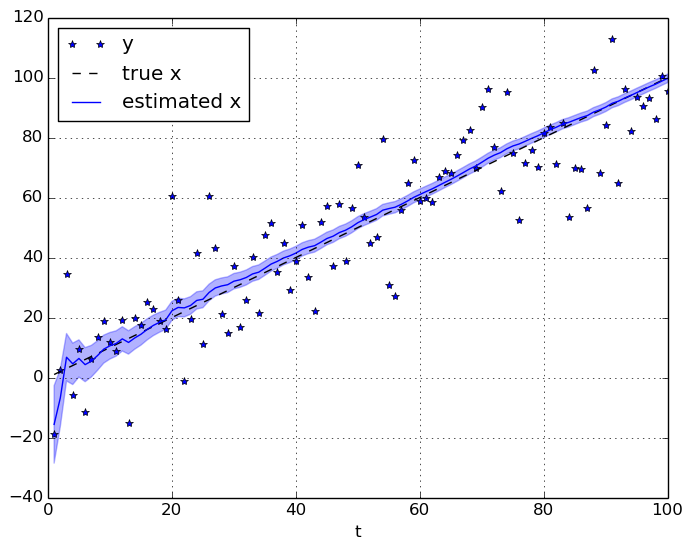

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


PyObject <matplotlib.legend.Legend object at 0x7fa5a6749fd0>

In [6]:
using PyPlot

plot(collect(1:n_samples), y, "b*", label="y")
plot(collect(1:n_samples), x, "k--", label="true x")
plot(collect(1:n_samples), x_m, "b-", label="estimated x")
fill_between(collect(1:n_samples), x_m-sqrt(x_v), x_m+sqrt(x_v), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left")